# Петров Сергей Дмитриевич, Вариант 5

In [1]:
import module_lab1 as lab1
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def likelihood_func(x, M, B):
    delit = 2*np.pi * np.sqrt(np.linalg.det(B))

    for_exp = np.dot(
        (x  - M),
        np.linalg.inv(B)
    )
    for_exp = np.dot(
        for_exp,
        (x - M)
    )


    return np.exp(-for_exp/2)/delit

def create_likelihood_func(M, B):
    def inner_func(x):
        return likelihood_func(x, M, B)
    return inner_func

In [253]:
def create_data_for_class(N:list, M:list, B:list):
    class data:
        def __init__(self, N:list, M:list, B:list):
            temp_N = np.array(N)
            self.aprior_prob = temp_N/temp_N.sum()

            self.vectors = []
            self.likelihood_funcs = []
            for n, m, b in zip(N, M, B):

                var_xi = lab1.create_xi(n)
                self.vectors += [lab1.calc_x(var_xi, m, b)]

                # Вычисление м и б на основе векторов
                M_hat = lab1.calc_M_hat(self.vectors[-1])
                B_hat = lab1.calc_B_hat(self.vectors[-1])
                
                self.likelihood_funcs += [create_likelihood_func(M_hat, B_hat)]
                # self.likelihood_funcs += [create_likelihood_func(m, b)]

            self.c = np.ones([len(N), len(N)])
            self.c -= np.eye(len(N), len(N), 0)

        def find_borders(self):
            x_min = min([min(vec[:, 0]) for vec in self.vectors])
            x_max = max([max(vec[:, 0]) for vec in self.vectors])

            y_min = min([min(vec[:, 1]) for vec in self.vectors])
            y_max = max([max(vec[:, 1]) for vec in self.vectors])

            return ([x_min, x_max], [y_min, y_max])

        def plot_dots(self,steps = None):
            borders = self.find_borders()

            if(steps == None):
                plt.xlim(borders[0])
                plt.ylim(borders[1])
                for target, vec in enumerate(self.vectors):
                    vec = np.array(vec)
                    plt.scatter(vec[:,0], vec[:,1], label = target)
            else:
                plt.xlim(0, steps[0])
                plt.ylim(0, steps[1])

                for target, vec in enumerate(self.vectors):
                    vec = np.array(vec)

                    vec[:,0] = (vec[:,0] - borders[0][0])/(borders[0][1] - borders[0][0]) * steps[0]
                    vec[:,1] = (vec[:,1] - borders[1][0])/(borders[1][1] - borders[1][0]) * steps[1]
                    plt.scatter(vec[:,0], vec[:,1], label = target)

        def prob_false_classif(self, ind, pred):
            vec = np.array(self.vectors[ind])
            return sum([pred(v) != ind for v in vec])/vec.shape[0]
            # return sum([pred(v) < 0 for v in vec])/vec.shape[0]


    return data(N, M, B)

In [300]:
def create_bin_data_for_class(N:list, P:list, dim):
    class data:
        def __init__(self, N:list, P:list):
            temp_N = np.array(N)
            self.aprior_prob = temp_N/temp_N.sum()

            self.vectors = []
            self.likelihood_funcs = []
            for n, p in zip(N, P):

                var_xi = lab1.create_xi(n)
                self.vectors += [lab1.create_bin_vec(n, p, dim)]

                # Вычисление м и б на основе векторов
                M_hat = lab1.calc_M_hat(self.vectors[-1])
                B_hat = lab1.calc_B_hat(self.vectors[-1])
                
                self.likelihood_funcs += [create_likelihood_func(M_hat, B_hat)]
                # self.likelihood_funcs += [create_likelihood_func(m, b)]

            self.c = np.ones([len(N), len(N)])
            self.c -= np.eye(len(N), len(N), 0)

        def find_borders(self):
            x_min = min([min(vec[:, 0]) for vec in self.vectors])
            x_max = max([max(vec[:, 0]) for vec in self.vectors])

            y_min = min([min(vec[:, 1]) for vec in self.vectors])
            y_max = max([max(vec[:, 1]) for vec in self.vectors])

            return ([x_min, x_max], [y_min, y_max])

        def plot_dots(self,steps = None):
            borders = self.find_borders()

            if(steps == None):
                plt.xlim(borders[0])
                plt.ylim(borders[1])
                for target, vec in enumerate(self.vectors):
                    vec = np.array(vec)
                    plt.scatter(vec[:,0], vec[:,1], label = target)
            else:
                plt.xlim(0, steps[0])
                plt.ylim(0, steps[1])

                for target, vec in enumerate(self.vectors):
                    vec = np.array(vec)

                    vec[:,0] = (vec[:,0] - borders[0][0])/(borders[0][1] - borders[0][0]) * steps[0]
                    vec[:,1] = (vec[:,1] - borders[1][0])/(borders[1][1] - borders[1][0]) * steps[1]
                    plt.scatter(vec[:,0], vec[:,1], label = target)

        def prob_false_classif(self, ind, pred):
            vec = np.array(self.vectors[ind])
            return sum([pred(v) != ind for v in vec])/vec.shape[0]
            # return sum([pred(v) < 0 for v in vec])/vec.shape[0]


    return data(N, P)

### Задача 1
Построить байесовскую решающую границу между классами $\Omega 0$ и $\Omega 1$ двумерных нормально распределенных векторов признаков для случая равных корреляционных матриц и равных априорных вероятностей и изобразить ее графически. Вычислить вероятности ошибочной классификации и суммарную вероятность ошибочной классификации в этом случае
    

In [254]:
class BiasClassifier:
    def __init__(self, data:create_data_for_class):
        self.data = data

    def vec_prob(self, vec):
        return np.array([np.log(apr) + np.log(likelihood(vec)) for apr, likelihood in zip(self.data.aprior_prob, self.data.likelihood_funcs)])
        
    def pred_class(self, vec):
        return np.argmax(self.vec_prob(vec))
    
    def create_pred_img(self, steps = [16, 10], cmap = 'viridis'):
        borders = self.data.find_borders()
        x_linspace = np.linspace(borders[0][0], borders[0][1], steps[0])
        y_linspace = np.linspace(borders[1][0], borders[1][1], steps[1])

        lam = lambda x, y: self.pred_class(np.array([x, y]))
        
        matrix = [[lam(x,y) for x in x_linspace] for y in y_linspace]

        plt.imshow(matrix,cmap = cmap, origin = 'lower')
        self.data.plot_dots(steps)
    
    def prob_false_classif(self, ind):
        return self.data.prob_false_classif(ind, self.pred_class)

In [255]:
baies = BiasClassifier(
    create_data_for_class(
        N=[300, 300],
        M=[lab1.M1, lab1.M2],
        B=[lab1.B_diag_symm, lab1.B_diag_symm]
    )
)

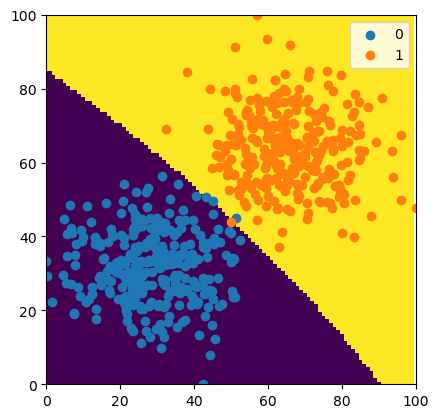

In [256]:
baies.create_pred_img([100, 100])
plt.legend()
plt.show()

In [257]:
baies.prob_false_classif(0)

0.0033333333333333335

### Задача 2 
Построить минимаксный классификатор и классификатор НейманаПирсона для вероятности ошибки первого рода $p_0 = 0.05$ для двух классов Ω0 и Ω1 двумерных нормально распределенных векторов признаков в случае равных корреляционных матриц. Изобразить решающие границы полученных классификаторов графически. 

    Опять не понял, просто удалил априорную вероятность у баеса

In [145]:
class MinMaxClassifier:
    def __init__(self, data:create_data_for_class):
        self.data = data

    def vec_prob(self, vec):
        return np.array([likelihood(vec) for likelihood in self.data.likelihood_funcs])
    
    def pred_class(self, vec):
        return np.argmax(self.vec_prob(vec))
    
    def create_pred_img(self, steps = [16, 10], cmap = 'viridis'):
        borders = self.data.find_borders()
        x_linspace = np.linspace(borders[0][0], borders[0][1], steps[0])
        y_linspace = np.linspace(borders[1][0], borders[1][1], steps[1])

        lam = lambda x, y: self.pred_class(np.array([x, y]))
        
        matrix = [[lam(x,y) for x in x_linspace] for y in y_linspace]

        plt.imshow(matrix,cmap = cmap, origin = 'lower')
        self.data.plot_dots(steps)

In [148]:
minmax = MinMaxClassifier(
    create_data_for_class(
        N=[300, 150],
        M=[lab1.M1, lab1.M2],
        B=[lab1.B_diag_symm, lab1.B_diag_symm]
    )
)

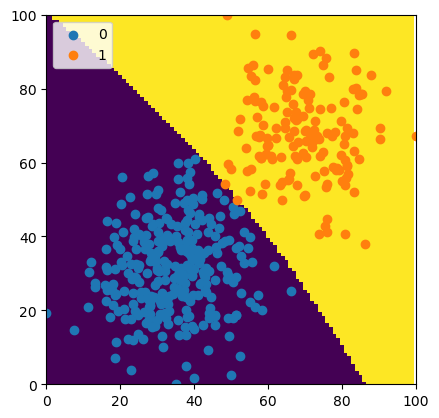

In [149]:
minmax.create_pred_img([100, 100])
plt.legend()
plt.show()

In [64]:
class NeymanPearsonClassifier:
    def __init__(self, data:create_data_for_class, p:float):
        self.data = data
        self.p = p

    def vec_prob(self, vec):
        return self.data.likelihood_funcs[1](vec)/self.data.likelihood_funcs[0](vec) 
    
    def pred_class(self, vec):
        return int(self.vec_prob(vec) > self.p)
    
    def create_pred_img(self, steps = [16, 10], cmap = 'viridis'):
        borders = self.data.find_borders()
        x_linspace = np.linspace(borders[0][0], borders[0][1], steps[0])
        y_linspace = np.linspace(borders[1][0], borders[1][1], steps[1])

        lam = lambda x, y: self.pred_class(np.array([x, y]))
        
        matrix = [[lam(x,y) for x in x_linspace] for y in y_linspace]

        plt.imshow(matrix,cmap = cmap, origin = 'lower')
        self.data.plot_dots(steps)

In [150]:
NeyPear = NeymanPearsonClassifier(
    create_data_for_class(
        N=[300, 150],
        M=[lab1.M1, lab1.M2],
        B=[lab1.B_diag_symm, lab1.B_diag_symm]
    ),
    p = 0.05
)

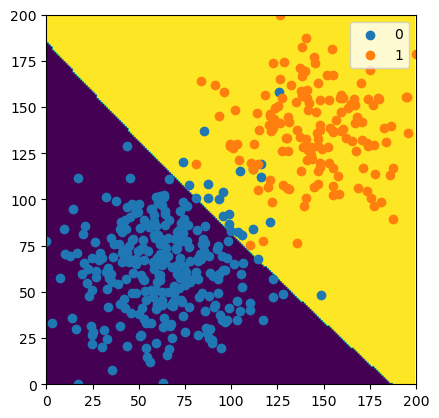

In [151]:
NeyPear.create_pred_img([200, 200])
plt.legend()
plt.show()

### Задача 3
Построить байесовскую решающую границу между классами Ω0 , Ω1 и Ω2 двумерных нормально распределенных векторов признаков для неравных корреляционных матриц и равных априорных вероятностей. Изобразить полученные решающие границы графически. Для любых двух классов оценить экспериментально вероятности ошибочной классификации в этом случае и определить относительную погрешность полученных оценок для заданного объема обучающей выборки N. Определить объем обучающей выборки, обеспечивающий получение оценок вероятностей ошибочной классификации с погрешностью не более 5%.

In [297]:
baies3 = BiasClassifier(
    create_data_for_class(
        N=[100, 100, 100],
        M=[lab1.M1, lab1.M2, lab1.M3],
        B=[lab1.B_diag_asymm, lab1.B_diag_symm, lab1.diag_flip(lab1.B_diag_asymm)]
    )
)

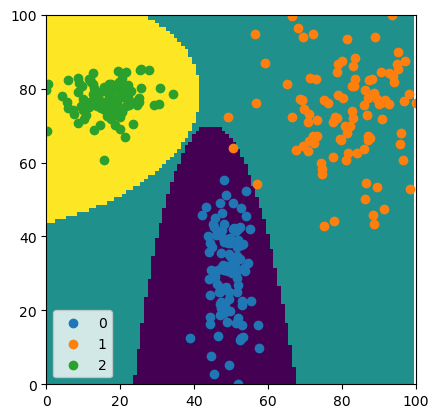

In [298]:
baies3.create_pred_img([100, 100])
plt.legend()
plt.show()

Эксперементальная вероятность ошибочной классификации

    Не удалось получить ошибку болье 1%

In [299]:
print(baies3.prob_false_classif(0))
print(baies3.prob_false_classif(1))
print(baies3.prob_false_classif(2))

0.0
0.01
0.0


### Задача 4
Построить байесовскую разделяющую границу между классами Ω0 и Ω1 двумерных бинарных векторов признаков. Вычислить вероятности ошибочной классификации аналитически и оценить их экспериментально. 

In [308]:
baies_bin = BiasClassifier(
    create_bin_data_for_class(
        N=[100, 100, 100],
        P=[0.1, 0.5, 0.9],
        dim=10
    )
)

In [309]:
print(baies_bin.prob_false_classif(0))
print(baies_bin.prob_false_classif(1))
print(baies_bin.prob_false_classif(2))

0.11
0.06
0.12
